## Load rs-fMRI dataset

In [7]:
from nilearn import datasets

# Add dataset to Original_Data and include all confounds
data = datasets.fetch_development_fmri(data_dir='../Original_Data', reduce_confounds=False)


Dataset created in ../Original_Data/development_fmri


Dataset created in ../Original_Data/development_fmri/development_fmri



Downloaded 16041 of 16041 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68285 of 68285 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5642698 of 5642698 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 67851 of 67851 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 4946416 of 4946416 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 69170 of 69170 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5875966 of 5875966 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68464 of 68464 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5845425 of 5845425 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68189 of 68189 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6522229 of 6522229 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 69463 of 69463 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6139107 of 6139107 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68010 of 68010 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5919127 of 5919127 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68464 of 68464 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5642114 of 5642114 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68144 of 68144 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6081959 of 6081959 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68573 of 68573 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5880763 of 5880763 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68920 of 68920 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6432694 of 6432694 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68804 of 68804 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5606383 of 5606383 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68862 of 68862 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6274191 of 6274191 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68887 of 68887 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5784982 of 5784982 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68816 of 68816 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6379656 of 6379656 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68831 of 68831 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5608665 of 5608665 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68571 of 68571 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5862117 of 5862117 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68780 of 68780 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5731564 of 5731564 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 69141 of 69141 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6665665 of 6665665 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68319 of 68319 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5995324 of 5995324 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68161 of 68161 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6372324 of 6372324 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68394 of 68394 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6277893 of 6277893 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68532 of 68532 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5831225 of 5831225 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68431 of 68431 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5942641 of 5942641 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68474 of 68474 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6079969 of 6079969 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68786 of 68786 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5898818 of 5898818 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68507 of 68507 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6201883 of 6201883 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68204 of 68204 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6037995 of 6037995 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 67833 of 67833 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6331499 of 6331499 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68344 of 68344 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5768950 of 5768950 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68524 of 68524 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6070427 of 6070427 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68823 of 68823 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6236679 of 6236679 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68703 of 68703 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5402479 of 5402479 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68468 of 68468 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6293165 of 6293165 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68130 of 68130 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6136523 of 6136523 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68340 of 68340 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5837641 of 5837641 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 71331 of 71331 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6118892 of 6118892 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68533 of 68533 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6453693 of 6453693 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68590 of 68590 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6176491 of 6176491 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68630 of 68630 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6225801 of 6225801 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68331 of 68331 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6232787 of 6232787 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68425 of 68425 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 7361169 of 7361169 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68894 of 68894 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6586819 of 6586819 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68848 of 68848 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6111716 of 6111716 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68243 of 68243 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6067448 of 6067448 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 69265 of 69265 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6122113 of 6122113 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68479 of 68479 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6295931 of 6295931 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68301 of 68301 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6384587 of 6384587 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 67912 of 67912 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5934622 of 5934622 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68499 of 68499 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6316470 of 6316470 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 67733 of 67733 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6020576 of 6020576 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68275 of 68275 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6551822 of 6551822 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68896 of 68896 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6116459 of 6116459 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68182 of 68182 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6752586 of 6752586 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68403 of 68403 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6023997 of 6023997 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68534 of 68534 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6312316 of 6312316 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 69162 of 69162 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6031594 of 6031594 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 71350 of 71350 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6123172 of 6123172 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68620 of 68620 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6203305 of 6203305 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 67794 of 67794 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6253721 of 6253721 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 67901 of 67901 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6168810 of 6168810 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68188 of 68188 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6287468 of 6287468 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68229 of 68229 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6146235 of 6146235 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68249 of 68249 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6358784 of 6358784 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 67891 of 67891 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6199206 of 6199206 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68437 of 68437 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6249029 of 6249029 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68124 of 68124 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5741735 of 5741735 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68213 of 68213 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5950135 of 5950135 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68335 of 68335 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5967515 of 5967515 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 66955 of 66955 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5527830 of 5527830 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68289 of 68289 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5894024 of 5894024 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68575 of 68575 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6131100 of 6131100 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68135 of 68135 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5344522 of 5344522 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68723 of 68723 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6235792 of 6235792 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68617 of 68617 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5622722 of 5622722 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68395 of 68395 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5926863 of 5926863 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 67223 of 67223 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5552738 of 5552738 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68139 of 68139 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6178036 of 6178036 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 67858 of 67858 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5978758 of 5978758 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68251 of 68251 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5920556 of 5920556 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68615 of 68615 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6832999 of 6832999 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 67831 of 67831 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6033214 of 6033214 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 67779 of 67779 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5893493 of 5893493 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68790 of 68790 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5559817 of 5559817 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68280 of 68280 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6121201 of 6121201 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68388 of 68388 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5898601 of 5898601 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68421 of 68421 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6155053 of 6155053 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 69778 of 69778 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6826881 of 6826881 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68481 of 68481 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6022319 of 6022319 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68455 of 68455 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6569115 of 6569115 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68536 of 68536 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6334175 of 6334175 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68284 of 68284 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5691399 of 5691399 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68556 of 68556 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5800254 of 5800254 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 67258 of 67258 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5839012 of 5839012 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68515 of 68515 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5764489 of 5764489 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68640 of 68640 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6539240 of 6539240 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 67662 of 67662 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6032799 of 6032799 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68519 of 68519 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6186037 of 6186037 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68462 of 68462 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6320034 of 6320034 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 67845 of 67845 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5838968 of 5838968 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 67588 of 67588 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6354223 of 6354223 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 67283 of 67283 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5765351 of 5765351 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68014 of 68014 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5734693 of 5734693 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68343 of 68343 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6239473 of 6239473 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68270 of 68270 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6195387 of 6195387 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 67193 of 67193 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5972457 of 5972457 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68571 of 68571 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5660892 of 5660892 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 67692 of 67692 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6337948 of 6337948 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68189 of 68189 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5875437 of 5875437 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68309 of 68309 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6024712 of 6024712 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 67372 of 67372 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5943254 of 5943254 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68290 of 68290 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6195389 of 6195389 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68732 of 68732 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6295717 of 6295717 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 67967 of 67967 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6061903 of 6061903 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68313 of 68313 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5995648 of 5995648 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68057 of 68057 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6737719 of 6737719 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 67555 of 67555 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6270886 of 6270886 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68526 of 68526 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5940249 of 5940249 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 67282 of 67282 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6003779 of 6003779 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68368 of 68368 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6293437 of 6293437 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68563 of 68563 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6383893 of 6383893 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 67866 of 67866 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6057828 of 6057828 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68003 of 68003 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6043299 of 6043299 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68254 of 68254 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5910235 of 5910235 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68261 of 68261 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5875145 of 5875145 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68988 of 68988 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6180849 of 6180849 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68093 of 68093 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6214116 of 6214116 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 67752 of 67752 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6236204 of 6236204 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 67860 of 67860 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6146714 of 6146714 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68272 of 68272 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6031941 of 6031941 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68243 of 68243 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5386122 of 5386122 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68517 of 68517 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5825310 of 5825310 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68513 of 68513 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6100455 of 6100455 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 69168 of 69168 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5271757 of 5271757 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68752 of 68752 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5328170 of 5328170 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 67827 of 67827 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5277452 of 5277452 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 67560 of 67560 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5378037 of 5378037 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68979 of 68979 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 4919277 of 4919277 bytes (100.0%,    0.0s remaining) ...done. (4 seconds, 0 min)


Downloaded 67057 of 67057 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5149406 of 5149406 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68452 of 68452 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5342091 of 5342091 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68490 of 68490 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5528414 of 5528414 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68457 of 68457 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5399764 of 5399764 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68788 of 68788 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5252477 of 5252477 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68762 of 68762 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6201575 of 6201575 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 67502 of 67502 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5683006 of 5683006 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 69089 of 69089 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5393091 of 5393091 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68710 of 68710 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5888116 of 5888116 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 69193 of 69193 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5802574 of 5802574 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68693 of 68693 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5885731 of 5885731 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68055 of 68055 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5433046 of 5433046 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 67938 of 67938 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5538534 of 5538534 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68735 of 68735 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5446455 of 5446455 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68685 of 68685 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5715543 of 5715543 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 69573 of 69573 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5996720 of 5996720 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)


Downloaded 68148 of 68148 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5817840 of 5817840 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


In [9]:
from datalad import api

api.create(path='../Original_Data', force=True)

[INFO] Creating a new annex repo at /Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data 


<Dataset path=/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data>

In [10]:
api.save(path='../Original_Data', message='Fetch development_fMRI dataset using Nilearn and create DataLad dataset')

[{'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/development_fmri/development_fmri/participants.tsv',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/development_fmri/development_fmri/sub-pixar001_task-pixar_desc-confounds_regressors.tsv',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/development_fmri/development_fmri/sub-pixar001_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Dat

## Functional atlas

### Load BASC multiscale atlas

In [29]:
# Load atlas with 64 ROIs
multiscale = datasets.fetch_atlas_basc_multiscale_2015(data_dir='../Original_Data')
atlas_filename = multiscale.scale064


Dataset created in ../Original_Data/basc_multiscale_2015



Downloaded 193985 of 193985 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from ../Original_Data/basc_multiscale_2015/3cbcf0eeb3f666f55070aba1db9a758f/1861819..... done.


In [30]:
api.save(path='../Original_Data/basc_multiscale_2015', message='Download BASC multiscale atlas')

[{'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/README.md',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale007.nii.gz',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale012.nii.gz',
  'type': 'file',
  'refds': '/Users/Stor

### Feature extraction

In [12]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.connectome import vec_to_sym_matrix
import numpy as np

# Initialize masker
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, 
                           memory='nilearn_cache', verbose=0)

# Initialize correlation measure for individual correlation matrix generation
correlation_measure_ind = ConnectivityMeasure(kind='correlation', vectorize=True, # Set to vectorize
                                         discard_diagonal=False)                  # Keep diagonal

all_features = [] # Empty list for containing all features (correlations)

# Extract signal based on labels defined by atlas
for i,sub in enumerate(data.func):
    # Extract timeseries from each ROI in atlas
    time_series = masker.fit_transform(sub, confounds=data.confounds[i])
    # Create region x region correlation matrix
    correlation_matrix_ind = correlation_measure_ind.fit_transform([time_series])[0]
    # Add correlation matrix to feature container
    all_features.append(correlation_matrix_ind)
    # Track progress
    print('finished %s of %s'%(i+1,len(data.func)))
    
# Convert feature list to numpy array
X_features = np.array(all_features)

ind_matrices = vec_to_sym_matrix(X_features)

finished 1 of 155
finished 2 of 155
finished 3 of 155
finished 4 of 155
finished 5 of 155
finished 6 of 155
finished 7 of 155
finished 8 of 155
finished 9 of 155
finished 10 of 155
finished 11 of 155
finished 12 of 155
finished 13 of 155
finished 14 of 155
finished 15 of 155
finished 16 of 155
finished 17 of 155
finished 18 of 155
finished 19 of 155
finished 20 of 155
finished 21 of 155
finished 22 of 155
finished 23 of 155
finished 24 of 155
finished 25 of 155
finished 26 of 155
finished 27 of 155
finished 28 of 155
finished 29 of 155
finished 30 of 155
finished 31 of 155
finished 32 of 155
finished 33 of 155
finished 34 of 155
finished 35 of 155
finished 36 of 155
finished 37 of 155
finished 38 of 155
finished 39 of 155
finished 40 of 155
finished 41 of 155
finished 42 of 155
finished 43 of 155
finished 44 of 155
finished 45 of 155
finished 46 of 155
finished 47 of 155
finished 48 of 155
finished 49 of 155
finished 50 of 155
finished 51 of 155
finished 52 of 155
finished 53 of 155
fi

### Plot correlation matrix

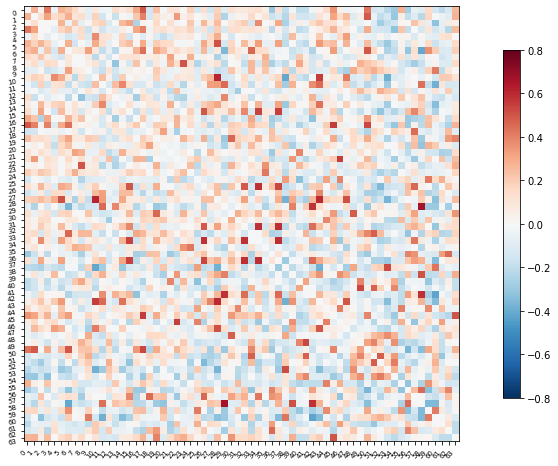

In [16]:
from nilearn import plotting

# Mask out major diagonal
np.fill_diagonal(ind_matrices[40], 0)

plotting.plot_matrix(ind_matrices[40], figure=(10, 8),   
                     labels=range(time_series.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)

### Feature extraction for model

In [17]:
# Initialize correlation measure for SVR model
# Set to vectorize
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True, # Set to vectorize
                                         discard_diagonal=True)               # Discard diagonal

all_features = [] # Empty list for containing all features (correlations)

# Extract signal based on labels defined by atlas
for i,sub in enumerate(data.func):
    # Extract timeseries from each ROI in atlas
    time_series = masker.fit_transform(sub, confounds=data.confounds[i])
    # Create region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # Add correlation matrix to feature container
    all_features.append(correlation_matrix)
    # Track progress
    print('finished %s of %s'%(i+1,len(data.func)))
    
# Convert feature list to numpy array
X_features = np.array(all_features)

finished 1 of 155
finished 2 of 155
finished 3 of 155
finished 4 of 155
finished 5 of 155
finished 6 of 155
finished 7 of 155
finished 8 of 155
finished 9 of 155
finished 10 of 155
finished 11 of 155
finished 12 of 155
finished 13 of 155
finished 14 of 155
finished 15 of 155
finished 16 of 155
finished 17 of 155
finished 18 of 155
finished 19 of 155
finished 20 of 155
finished 21 of 155
finished 22 of 155
finished 23 of 155
finished 24 of 155
finished 25 of 155
finished 26 of 155
finished 27 of 155
finished 28 of 155
finished 29 of 155
finished 30 of 155
finished 31 of 155
finished 32 of 155
finished 33 of 155
finished 34 of 155
finished 35 of 155
finished 36 of 155
finished 37 of 155
finished 38 of 155
finished 39 of 155
finished 40 of 155
finished 41 of 155
finished 42 of 155
finished 43 of 155
finished 44 of 155
finished 45 of 155
finished 46 of 155
finished 47 of 155
finished 48 of 155
finished 49 of 155
finished 50 of 155
finished 51 of 155
finished 52 of 155
finished 53 of 155
fi

### Plot feature matrix

Text(0, 0.5, 'Subjects')

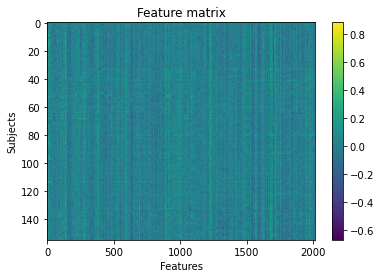

In [18]:
import matplotlib.pyplot as plt

plt.imshow(X_features, aspect='auto')
plt.colorbar()
plt.title('Feature matrix')
plt.xlabel('Features')
plt.ylabel('Subjects')

### Load phenotypic information

In [19]:
import pandas

pheno = pandas.DataFrame(data.phenotypic)
pheno.head()

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness
0,sub-pixar123,27.06,Adult,adult,F,R
1,sub-pixar124,33.44,Adult,adult,M,R
2,sub-pixar125,31.00,Adult,adult,M,R
3,sub-pixar126,19.00,Adult,adult,F,R
4,sub-pixar127,23.00,Adult,adult,F,R


### Assign Age to variable

In [23]:
y_age = pheno['Age']

### Assess class balance

In [21]:
age_class = pheno['AgeGroup']
age_class.value_counts()

8-12yo    34
5yo       34
Adult     33
7yo       23
3yo       17
4yo       14
Name: AgeGroup, dtype: int64

### Generate training/validation splits

In [24]:
from sklearn.model_selection import train_test_split

# Split sample to training/validation with a 75/25 ratio
# Stratify by age class, shuffle data

n_val = 10

X_train_container = []
X_val_container = []
y_train_container = []
y_val_container = []

for i in range(n_val):
    X_train, X_val, y_train, y_val = train_test_split(
                                                    X_features, # x
                                                    y_age, # y
                                                    test_size = 0.25, # 75%/25% split  
                                                    shuffle = True, # Shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    #random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

    X_train_container.append(X_train)
    X_val_container.append(X_val)
    y_train_container.append(y_train)
    y_val_container.append(y_val)
    
# Print size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_val))

training: 116 testing: 39


### Define model for age prediction

In [25]:
from sklearn.svm import SVR
l_svr = SVR(kernel='linear')

### Fit model to training data using 10-fold CV

In [26]:
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

# Build a tiny pipeline that does feature selection (top 20% of features), 
# and then prediction with our linear svr model.
model = Pipeline([
    ('feature_selection',SelectPercentile(f_regression,percentile=20)),
    ('prediction', l_svr)
                 ])
y_pred_all = []
y_index_all = []

for j in range(len(X_train_container)):

    y_pred = [] # a container to catch the predictions from each fold
    y_index = [] # just in case, the index for each prediction

    # First we create 10 splits of the data
    skf = KFold(n_splits=10, shuffle=True, random_state=123)

    # For each split, assemble the train and test samples 
    for tr_ind, te_ind in skf.split(X_train_container[j]):
        X_tr = X_train_container[j][tr_ind]
        y_tr = y_train_container[j].values[tr_ind]
        X_te = X_train_container[j][te_ind]
        y_index += list(te_ind) # store the index of samples to predict
    
        # and run our pipeline 
        model.fit(X_tr, y_tr) # fit the data to the model using our mini pipeline
        predictions = model.predict(X_te).tolist() # get the predictions for this fold
        y_pred += predictions # add them to the list of predictions
        
    y_index_all.append(y_index)
    y_pred_all.append(y_pred)

R2: 0.6484653555008462
MAE: 3.319689664458773


Text(0, 0.5, 'Log Age')

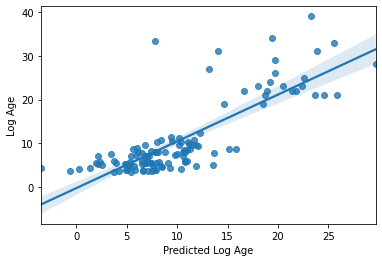

In [28]:
# Check CV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import seaborn as sns

k=9

acc = r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k])
mae = mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k])

print('R2:',acc)
print('MAE:',mae)

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')